## Example to test patch clamp model.
This script tests if patch-clamp model was buit into a shared object C library and runs properly.

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

In [62]:
data = pd.read_csv('../data/traces/2020_12_22_0033.csv', index_col=0)

In [63]:
df_new = pd.DataFrame(np.reshape(data.I_out, [15, 12000])).T

In [64]:
df_new['t'] = df_protocol.t

In [65]:
pd.read_csv('../data/traces/inactivation#1.csv')

,t,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.00000,-24.4141,-65.9180,-84.2285,-186.157,-121.155,-187.378,-312.805,-236.206,-144.653,-118.713,-182.495,-88.1958,-91.5527,-130.615,-96.1304
1,0.00005,-24.1089,-66.2231,-84.8389,-186.462,-121.460,-187.988,-312.195,-236.511,-144.653,-118.103,-182.800,-87.5854,-91.5527,-130.310,-96.1304
2,0.00010,-24.1089,-66.5283,-85.1440,-186.462,-122.070,-188.599,-312.500,-236.511,-144.043,-118.103,-183.411,-87.5854,-91.5527,-130.005,-95.8252
3,0.00015,-24.1089,-66.2231,-85.1440,-186.462,-122.681,-188.904,-312.805,-236.816,-144.653,-117.798,-183.411,-86.9751,-91.2476,-130.005,-96.1304
4,0.00020,-23.8037,-66.2231,-86.0596,-186.462,-122.986,-189.514,-312.805,-236.816,-144.653,-117.798,-183.105,-86.3647,-90.9424,-130.005,-95.8252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0.59975,-45.4712,-122.9860,-123.9010,-125.427,-154.419,-234.375,-325.928,-271.301,-185.852,-168.762,-201.721,-156.5550,-161.7430,-205.994,-209.3510
11996,0.59980,-45.4712,-122.9860,-123.2910,-125.122,-154.724,-234.070,-325.623,-271.606,-185.852,-168.762,-201.416,-156.8600,-161.4380,-206.604,-209.6560
11997,0.59985,-45.4712,-122.9860,-123.5960,-124.817,-154.724,-233.459,-325.317,-271.606,-185.547,-169.067,-201.111,-156.8600,-161.4380,-207.825,-209.9610
11998,0.59990,-45.7764,-123.2910,-122.9860,-124.207,-154.419,-234.070,-325.317,-271.301,-184.937,-169.678,-201.721,-157.1660,-161.4380,-209.045,-209.9610


In [58]:
df_new = df_new.loc[:, ['t', *np.arange(15)]]

In [60]:
df_new.to_csv('../data/traces/inactivation#1.csv')

'mpi_scripts' functions provide interface between python GA optimization library and model C library.
Load class InaModel from '../ga/mpi_scripts/ina_model.py'. InaModel should contain 3 methods:

**init(lib.so)** - interfacing .so C library with python. The C model data structure used as arguments of 'run' function from .so model library should be described here.

**run(args)** - the call of function from .so library should be defined there. In our case, firstly, this function calculates the initial state of model variables using df_initial_state_protocol defined below. Secondly, the voltage clamp experiment is simulated using df_protocol defined below. Every sweep uses the same initial state.

**status()** - should contain the status of output of .so library. It is necessary for genetic algorythm optimization functions. Succesful execution status should be equal to '2'.

In [4]:
sys.path.append('../ga/mpi_scripts/')
from ina_model import InaModel

 'libina.so' contatins C model library.

In [5]:
dirname = '../src/model_ctypes/PC_model/'# dir which contatins C model library.
filename_so = os.path.join(dirname, 'libina.so') #name of .so file

filename_so_abs = os.path.abspath(filename_so)
Ina = InaModel(filename_so_abs)

CVODE N_vector arrays are accesed by the names profided in the .csv files below from the python functions.


In [6]:
legend_algebraic = pd.read_csv('../src/model_ctypes/PC_model/legend_algebraic.csv', index_col='name').value
legend_constants = pd.read_csv('../src/model_ctypes/PC_model/legend_constants.csv', index_col='name').value
legend_states = pd.read_csv('../src/model_ctypes/PC_model/legend_states.csv', index_col='name').value

A = legend_algebraic.copy()
C = legend_constants.copy()
S = legend_states.copy()


Voltage-clamp protocol is described in df_protocol .csv file. Before the simulation, df_initial_state_protocol is used to prepare initial condition set of variables. Most often the latter is a holding potential which should be long enough to stabilize the gating variables.

In [8]:
df_protocol = pd.read_csv('../data/protocols/inactivation.csv')
df_initial_state_protocol = pd.read_csv('../data/initial_state_protocols/inactivation_initial_state.csv')

Model parameters can be changed directly using the names described in legend_constats .csv file.

In [6]:
# C.c_m = 5e-11
# C.R = 5e7

Run patch-clamp model

In [7]:
I, I_a = Ina.run(A,
                 S,
                 C,
                 df_protocol, 
                 df_initial_state_protocol, 
                 return_algebraic=True)

### Plot output current

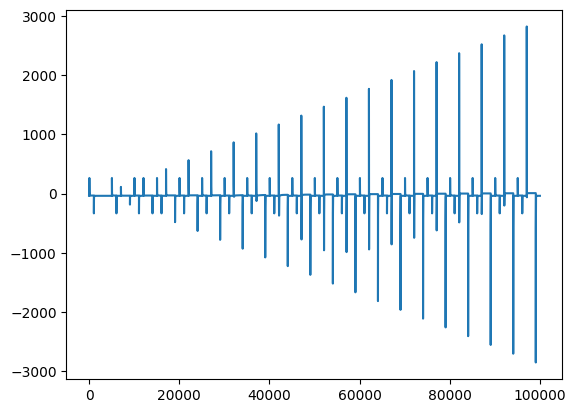

In [8]:
plt.plot(I.I_out)

### Plot voltage-clamp protocol

Text(0.5, 0, 't, s')

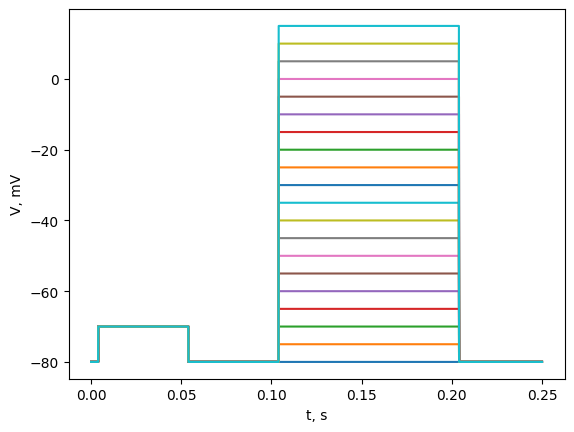

In [9]:
plt.plot(df_protocol.t, df_protocol.drop('t', axis=1))
plt.ylabel('V, mV')
plt.xlabel('t, s')